# Imports

In [237]:
# Remember to login to wandb!
import sys
import os 
import torch
import matplotlib.pyplot as plt
import copy 
import figure_names
from eigenestimation.toy_models.tms import AutoencoderSymmetric, AutoencoderParallel  # Import your model
from eigenestimation.evaluation.networks import DrawNeuralNetwork
from eigenestimation.eigenmodel.eigenmodel import EigenModel
from eigenestimation.utils.loss import MSELoss

# Initial TMS Model

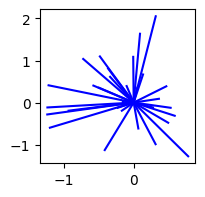

In [238]:
# Load TMS model
model_path = "../outputs/toy_models/high_rank_circuits.pt"
eigenmodel_path = "../outputs/eigenmodels/high_rank_circuits.pt"

model = torch.load(model_path)['model']
eigenmodel = torch.load(eigenmodel_path)['model']
# Plot TMS representations.
en = copy.deepcopy(model.W_in).detach().cpu().numpy().transpose()

plt.figure(figsize=(2,2))
for i in range(en.shape[1]):
  plt.plot([0, en[0,i]], [0,en[1,i]], 'b-')
plt.show()

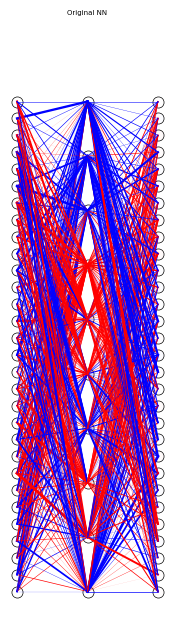

In [239]:
# Load TMS model
model_params = dict(model.named_parameters())
weights = {k:v for k,v in model_params.items() if 'b' not in k}
weights = {str(i):v.transpose(0,1) for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'b' in k}
biases = {str(i+1):v for i,v in enumerate(biases.values())}

f = DrawNeuralNetwork(weights, biases, "Original NN")


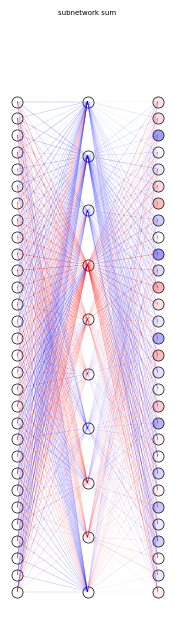

In [240]:

model_params = eigenmodel.reconstruct_network()
weights = {k:v.transpose(0,1) for k,v in model_params.items() if 'b' not in k}
weights = {str(i):v for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'b' in k}
biases = {str(i+1):v for i,v in enumerate(biases.values())}


figs = DrawNeuralNetwork(weights, biases, title='subnetwork sum')

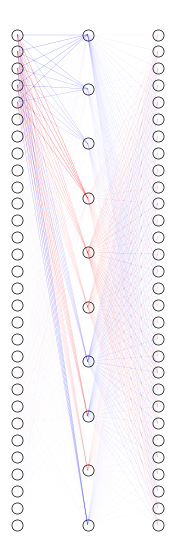

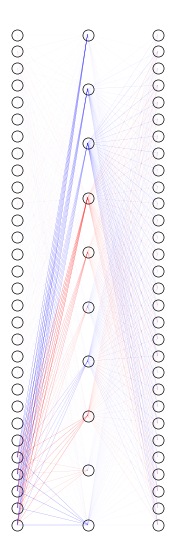

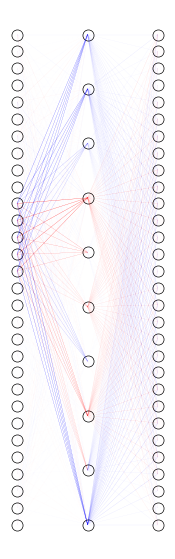

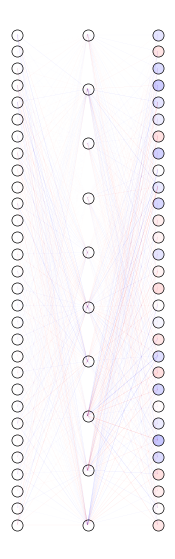

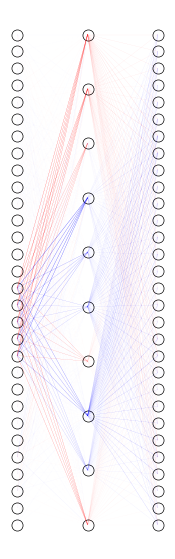

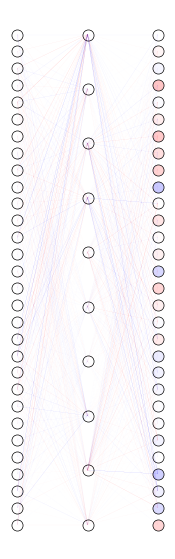

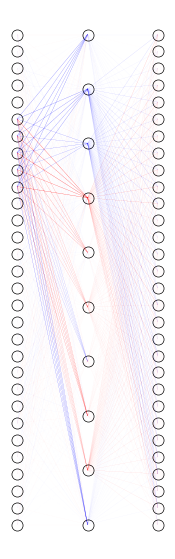

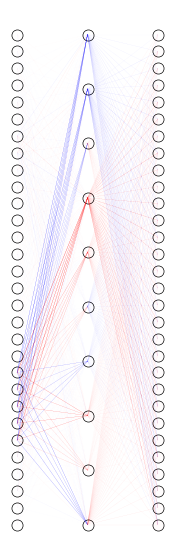

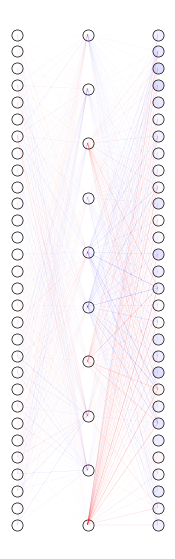

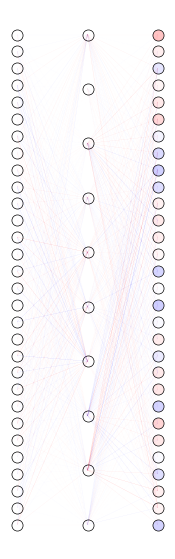

In [241]:
figs = []

for i, network in enumerate(eigenmodel.construct_subnetworks()):
    weights = {k:v.transpose(0,1) for k,v in network.items() if 'b' not in k}
    weights = {str(i):v for i,v in enumerate(weights.values())}

    biases = {k:v for k,v in network.items() if 'b' in k}
    biases = {str(i+1):v for i,v in enumerate(biases.values())}

    f = DrawNeuralNetwork(weights, biases)
    
    # Save as high_rank_subnetwork_{i}.svg
    f.savefig(f'../figures/{figure_names.high_rank_decomposition}/high_rank_subnetworks{i}.svg', transparent=True, bbox_inches='tight')


-----


# Loss of Various Ranks

AttributeError: module 'figure_names' has no attribute 'loss_over_ranks'

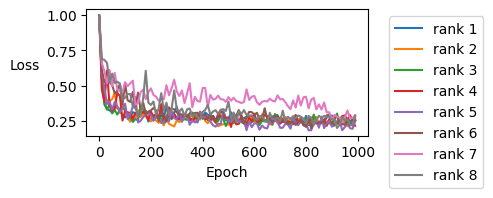

In [256]:
# Get loss metrics from a wandb run
import wandb
import pandas as pd

plt.figure(figsize=(5, 2))
for i in range(1, 9):
    project_path = f"brianna-chrisman-2024/high-rank-circuits-eigenmodel-rank{i}"  # entity/project
    api = wandb.Api()

    #project_path = f"brianna-chrisman-2024/tms-eigenmodel"  # entity/project
    runs = api.runs(project_path)

    # Get the latest run (first in the list)
    latest_run = runs[len(runs)-1]

    # Convert history (logged metrics) to a DataFrame
    history = latest_run.history()


    # Filter only loss metrics (adjust based on your naming convention)
    loss_columns = 'train/loss'
    loss_metrics = history[loss_columns]  # Include step count
    epochs = history['epoch']  # Include step count
    epochs = epochs[loss_metrics.notna()]
    loss_metrics = loss_metrics[loss_metrics.notna()]
    plt.plot(epochs, loss_metrics, label=f'rank {i}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss', rotation=0, labelpad=15)
plt.tight_layout()
plt.savefig(f'../figures/{figure_names.loss_over_ranks}.pdf', transparent=True, bbox_inches='tight')
plt.show()
